In [16]:
import numpy as np
import duckdb
import pandas as pd
import seaborn as sns
import math
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

In [17]:
data = pd.read_csv("BDC_2024_Womens_Data.csv")

In [18]:
data.columns

Index(['Date', 'Home Team', 'Away Team', 'Period', 'Clock',
       'Home Team Skaters', 'Away Team Skaters', 'Home Team Goals',
       'Away Team Goals', 'Team', 'Player', 'Event', 'X Coordinate',
       'Y Coordinate', 'Detail 1', 'Detail 2', 'Detail 3', 'Detail 4',
       'Player 2', 'X Coordinate 2', 'Y Coordinate 2'],
      dtype='object')

# Part 3: The Relationship Between Traffic and Scoring a Goal
# By Lauren Mok
In this portion, we will investigate the relationship between the presence of traffic and scoring a goal, as well as the relationship between one-timers and scoring a goal. Traffic refers to the gathering of many players in one area, usually in front of the net. A one-timer is a shot that occurs when a player meets a teammate's pass with an immediate slapshot, without any attempt to control the puck on their stick. We hypothesize that the presence of traffic correlates with fewer scores. 

In [19]:
filtered_data = duckdb.sql("""
                            SELECT Player, Event, "Detail 1", "Detail 3", "Detail 4"
                           FROM data
                           WHERE (Event = 'Goal' OR Event = 'Shot')
                            """).df()

In [20]:
mask = (filtered_data['Detail 3'].notna() & filtered_data['Detail 4'].notna())
filtered_data = filtered_data[mask] 

In [21]:
filtered_data

,Player,Event,Detail 1,Detail 3,Detail 4
0,Hilary Knight,Goal,Wristshot,f,f
1,Brianne Jenner,Goal,Wristshot,f,f
2,Taylor Heise,Goal,Snapshot,f,t
3,Alex Carpenter,Goal,Wristshot,f,f
4,Megan Keller,Shot,Snapshot,f,f
...,...,...,...,...,...
418,Taylor Heise,Shot,Wristshot,t,f
419,Taylor Heise,Shot,Wristshot,f,f
420,Ella Shelton,Shot,Wristshot,t,f
421,Sarah Nurse,Shot,Wristshot,f,f


In [22]:
filtered_data = filtered_data.rename(columns={'Detail 1': 'Shot Type', 'Detail 3': 'Traffic', 'Detail 4': 'One Timer'})
filtered_data

,Player,Event,Shot Type,Traffic,One Timer
0,Hilary Knight,Goal,Wristshot,f,f
1,Brianne Jenner,Goal,Wristshot,f,f
2,Taylor Heise,Goal,Snapshot,f,t
3,Alex Carpenter,Goal,Wristshot,f,f
4,Megan Keller,Shot,Snapshot,f,f
...,...,...,...,...,...
418,Taylor Heise,Shot,Wristshot,t,f
419,Taylor Heise,Shot,Wristshot,f,f
420,Ella Shelton,Shot,Wristshot,t,f
421,Sarah Nurse,Shot,Wristshot,f,f


In [23]:
print(filtered_data['Traffic'].unique())
print(filtered_data['One Timer'].unique())

['f' 't']
['f' 't']


In [24]:
def convert_bool(value):
    if value == 't':
        return 1
    else:
        assert value == 'f'
        return 0

In [25]:
filtered_data['Traffic'] = filtered_data['Traffic'].apply(convert_bool)
filtered_data['One Timer'] = filtered_data['One Timer'].apply(convert_bool)

In [26]:
filtered_data

,Player,Event,Shot Type,Traffic,One Timer
0,Hilary Knight,Goal,Wristshot,0,0
1,Brianne Jenner,Goal,Wristshot,0,0
2,Taylor Heise,Goal,Snapshot,0,1
3,Alex Carpenter,Goal,Wristshot,0,0
4,Megan Keller,Shot,Snapshot,0,0
...,...,...,...,...,...
418,Taylor Heise,Shot,Wristshot,1,0
419,Taylor Heise,Shot,Wristshot,0,0
420,Ella Shelton,Shot,Wristshot,1,0
421,Sarah Nurse,Shot,Wristshot,0,0


In [27]:
def convert_event(value):
    if value == "Goal":
        return 1
    else:
        assert value == 'Shot'
        return 0

In [28]:
filtered_data['Event'] = filtered_data['Event'].apply(convert_event)

In [29]:
filtered_data

,Player,Event,Shot Type,Traffic,One Timer
0,Hilary Knight,1,Wristshot,0,0
1,Brianne Jenner,1,Wristshot,0,0
2,Taylor Heise,1,Snapshot,0,1
3,Alex Carpenter,1,Wristshot,0,0
4,Megan Keller,0,Snapshot,0,0
...,...,...,...,...,...
418,Taylor Heise,0,Wristshot,1,0
419,Taylor Heise,0,Wristshot,0,0
420,Ella Shelton,0,Wristshot,1,0
421,Sarah Nurse,0,Wristshot,0,0


In [30]:
print(filtered_data['Shot Type'].unique())

['Wristshot' 'Snapshot' 'Fan' 'Slapshot' 'Deflection' 'Wrap Around' 'Bat'
 'Poke']


In [31]:
shot_type_dummies = pd.get_dummies(filtered_data['Shot Type'])
shot_type_dummies = shot_type_dummies * 1
filtered_data = pd.concat([filtered_data, shot_type_dummies], axis=1)
filtered_data.drop(columns=['Shot Type'], inplace=True)
filtered_data = filtered_data.rename(columns={'Event': 'Goal Scored'})
filtered_data

,Player,Goal Scored,Traffic,One Timer,Bat,Deflection,Fan,Poke,Slapshot,Snapshot,Wrap Around,Wristshot
0,Hilary Knight,1,0,0,0,0,0,0,0,0,0,1
1,Brianne Jenner,1,0,0,0,0,0,0,0,0,0,1
2,Taylor Heise,1,0,1,0,0,0,0,0,1,0,0
3,Alex Carpenter,1,0,0,0,0,0,0,0,0,0,1
4,Megan Keller,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
418,Taylor Heise,0,1,0,0,0,0,0,0,0,0,1
419,Taylor Heise,0,0,0,0,0,0,0,0,0,0,1
420,Ella Shelton,0,1,0,0,0,0,0,0,0,0,1
421,Sarah Nurse,0,0,0,0,0,0,0,0,0,0,1


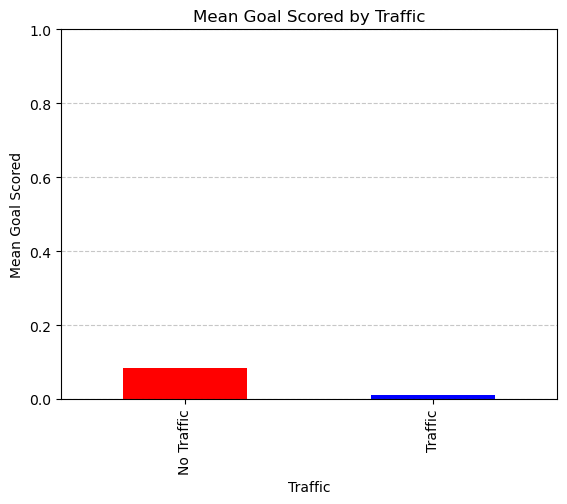

In [32]:
# Group by 'Traffic' and calculate the mean of 'Goal Scored'
grouped = filtered_data.groupby('Traffic')['Goal Scored'].mean()

# Plot a stacked bar chart
grouped.plot(kind='bar', stacked=True, color=['red', 'blue'])

plt.xlabel('Traffic')
plt.ylabel('Mean Goal Scored')
plt.title('Mean Goal Scored by Traffic')
plt.xticks([0, 1], ['No Traffic', 'Traffic'])
plt.ylim(0, 1)  # Set y-axis limits to represent proportions
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

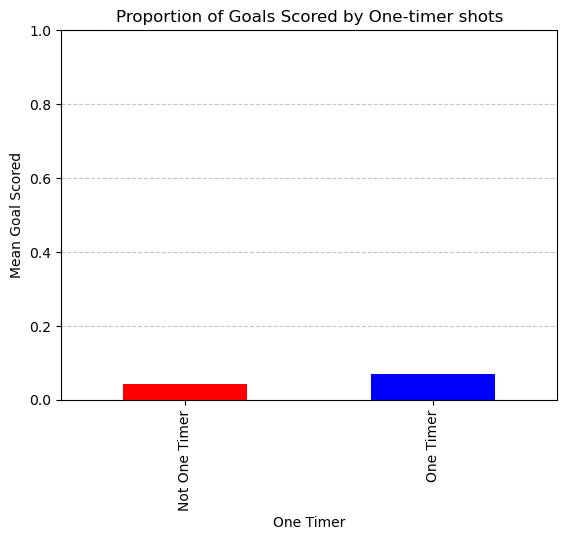

In [33]:
# Group by 'One-timer shots' and calculate the mean of 'Goal Scored'
grouped = filtered_data.groupby('One Timer')['Goal Scored'].mean()

# Plot a stacked bar chart
grouped.plot(kind='bar', stacked=True, color=['red', 'blue'])

plt.xlabel('One Timer')
plt.ylabel('Mean Goal Scored')
plt.title('Proportion of Goals Scored by One-timer shots')
plt.xticks([0, 1], ['Not One Timer', 'One Timer'])
plt.ylim(0, 1)  # Set y-axis limits to represent proportions
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [54]:
X = filtered_data[['Traffic']].values
#print (X)
y = filtered_data['Goal Scored'].values
#print (y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = sm.Logit(endog = y, exog = X).fit()
print (model.summary())
#model.fit(X_train, y_train)

y_prob = model.predict(X_test)
#y_prob

# coefficient is not big enough to make a different in the predicted value for y
# therefore, although the model has a coefficent of -4.6347, it converts to approximately
# 0.0097 in probability of the goal being scored. So although this result is significant,
# there is not a huge impact on whether there is traffic on whether the goal is made.

#y_pred = np.zeros(len(y_prob))
for i in range (len(y_pred)):
    if y_prob[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
#y_pred

Optimization terminated successfully.
         Current function value: 0.378973
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  423
Model:                          Logit   Df Residuals:                      422
Method:                           MLE   Df Model:                            0
Date:                Wed, 14 Feb 2024   Pseudo R-squ.:                 -0.9901
Time:                        20:35:20   Log-Likelihood:                -160.31
converged:                       True   LL-Null:                       -80.552
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -4.6347      0.711     -6.523      0.000      -6.027      -3.242


In [46]:
model_2 = LogisticRegression().fit(X, y)
model_2.coef_

predicted_y = model_2.predict(X_test)
predicted_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [50]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.5196850393700787
Precision: 0.0625
Recall: 0.8
